# Intervention Model Classifier

Predict the intervention model from the pubmed abstract of a clinical trial

In [1]:
%store -r abstracts_targets

df = abstracts_targets.ix[:, ['abstract', 'pmid', 'intervention_model']]
df = df[df.intervention_model.notnull()] # filter away abstracts which don't have an associated intervention model

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2126
Data columns (total 3 columns):
abstract              2085 non-null object
pmid                  2085 non-null object
intervention_model    2085 non-null object
dtypes: object(3)
memory usage: 65.2+ KB


In [2]:
df.groupby('intervention_model').size()

intervention_model
Crossover Assignment        157
Factorial Assignment         47
Parallel Assignment        1380
Single Group Assignment     501
dtype: int64

### View an Example from Each Class

In [3]:
labels = df.intervention_model.unique()

indexes = [df[df.intervention_model == label].iloc[0].name for label in labels]

for index in indexes:
    pm_url = 'https://www.google.com/search?q=pmid+' + df.iloc[index].pmid + '&btnI=I' # I'm Feeling Lucky
    
    print '*'*5, df.iloc[index].intervention_model, '*'*5
    print df.iloc[index].abstract
    print
    !google-chrome "{pm_url}"
    print

***** Parallel Assignment *****
D-Cycloserine, a partial agonist at the glycine site of the N-methyl-D-aspartate receptor, has demonstrated inconsistent efficacy for negative and cognitive symptoms of schizophrenia. The strongest evidence for efficacy has come from studies using D-cycloserine at a dose of 50 mg/day added to conventional antipsychotics in trials of 8 weeks duration or less. 
                 To assess the efficacy for negative symptoms and cognitive impairment of D-cycloserine augmentation of conventional antipsychotics in a 6-month trial. 
                 Fifty-five schizophrenia patients with prominent negative symptoms, treated with conventional antipsychotics, were randomly assigned to treatment with D-cycloserine 50 mg/day or placebo for 6 months in a double-blind, parallel group design. 
                 Twenty-six subjects completed the 6-month trial; drop-out rates did not differ between treatment groups. D-Cycloserine treatment did not differ from placebo trea

### Word Clouds for Each Class

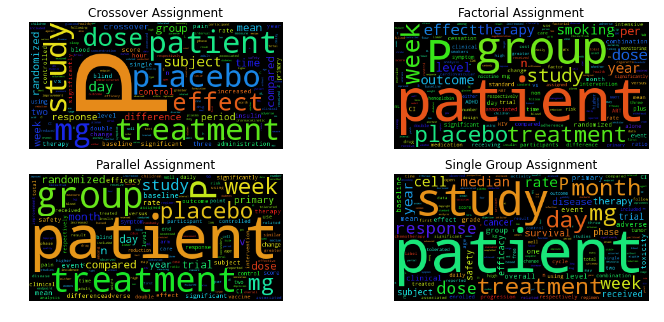

In [4]:
from support import word_cloud

fig = plt.figure(figsize=(12, 5))
plt.clf()

for i, label in enumerate(np.sort(df.intervention_model.unique()), start=1):
    axes = fig.add_subplot(2, 2, i)
    words = ' '.join(df[df.intervention_model == label].abstract)
    
    word_cloud(words, axes, label)
    
plt.axis('off')
plt.show()

### Vectorize Abstracts

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

X = vectorizer.fit_transform(df.abstract)

X.shape

(2085, 214831)

### Extract Vocabulary and Order Vocabulary

In [6]:
import operator

vocabulary = [word for word, index in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]

### Train Test Split

In [7]:
from sklearn.cross_validation import train_test_split

X_train, X_test, ys_train, ys_test = train_test_split(X, df.intervention_model)

X_train.shape, X_test.shape, ys_train.shape, ys_test.shape

((1563, 214831), (522, 214831), (1563,), (522,))

### Hyperparameters

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV

M, N = X_train.shape
K = 3 # number of folds for cross-validation

n_iter = int(np.ceil(10**6/(M-M/K))) # http://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use

alphas = [{'alpha': 10.0**-np.arange(1,7)[::-1]}]
n_iters = [{'n_iter': [5, 10, 100, 500, n_iter]}]

def search_params(clf, parameters, k=5):
    """Perform a grid search over the parameters
    
    k: the number of folds to be used for cross-validation
    
    """
    grid_search = GridSearchCV(clf, parameters, verbose=3, scoring='f1_macro', cv=k)
    
    grid_search.fit(X_train, ys_train)
    
    return grid_search

### Tune `alpha`

In [9]:
clf = SGDClassifier(class_weight='auto', n_iter=n_iter)

grid_search = search_params(clf, alphas, k=K)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] alpha=1e-06 .....................................................
[CV] ............................ alpha=1e-06, score=0.393195 -   3.5s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.5s
/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



[CV] alpha=1e-06 .....................................................
[CV] ............................ alpha=1e-06, score=0.470024 -   3.5s
[CV] alpha=1e-06 .....................................................
[CV] ............................ alpha=1e-06, score=0.438059 -   3.5s
[CV] alpha=1e-05 .....................................................
[CV] ............................ alpha=1e-05, score=0.380116 -   3.6s
[CV] alpha=1e-05 .....................................................
[CV] ............................ alpha=1e-05, score=0.469373 -   3.5s
[CV] alpha=1e-05 .....................................................
[CV] ............................ alpha=1e-05, score=0.448639 -   3.5s
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.383136 -   3.8s
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.469542 -   3.8s
[CV] 

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.2min finished


### Aggregate Performance

In [10]:
df = pd.DataFrame(grid_search.grid_scores_, columns=grid_search.grid_scores_[0]._fields)

scores = df.cv_validation_scores.apply(pd.Series)
scores = scores.rename(columns=lambda x: 's'+str(x))
scores['f1'], scores['err'] = scores.mean(axis=1), scores.std(axis=1)

alphas = df.parameters.apply(lambda x: pd.Series(x['alpha']))
alphas = alphas.rename(columns={0: 'alpha'})

df = pd.concat([alphas, scores], axis=1)

df

,alpha,s0,s1,s2,f1,err
0,0.000001,0.393195,0.470024,0.438059,0.433759,0.038594
1,0.000010,0.380116,0.469373,0.448639,0.432709,0.046713
2,0.000100,0.383136,0.469542,0.450707,0.434461,0.045436
3,0.001000,0.434462,0.536778,0.511550,0.494263,0.053303
4,0.010000,0.419268,0.534157,0.524352,0.492593,0.063690
5,0.100000,0.199079,0.199192,0.199653,0.199308,0.000304


### Plot Performance

(1e-07, 1)

/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


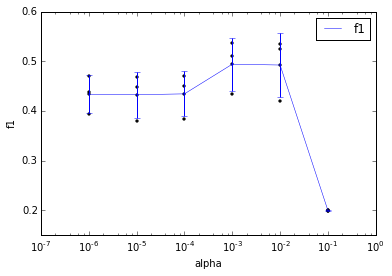

In [11]:
DOT_SIZE = 5

axes = df.plot(x='alpha', y='f1', logx=True, c='b', linewidth=.5)

for s in ['s{}'.format(k) for k in range(K)]:
    axes = df.plot(ax=axes, kind='scatter', x='alpha', y=s, logx=True, c='black', s=DOT_SIZE)
    
axes = df.plot(ax=axes, kind='scatter', x='alpha', y='f1', yerr=df.err, logx=True, s=DOT_SIZE)

axes.set_xlim(1e-7, 1)

In [12]:
best_clf = grid_search.best_estimator_

best_clf

SGDClassifier(alpha=0.001, average=False, class_weight='auto', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=959, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [13]:
grid_search.best_score_

0.49416480743082253

### Prediction on Test Set

In [14]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

import sklearn

predictions = best_clf.predict(X_test)

f1s = sklearn.metrics.f1_score(lb.fit_transform(ys_test), lb.fit_transform(predictions), average=None)
f1 = sklearn.metrics.f1_score(lb.fit_transform(ys_test), lb.fit_transform(predictions), average='macro')

import re
from collections import namedtuple

Classes = namedtuple('Classes', map(lambda s: re.sub('\s+', '_', s), best_clf.classes_))

print 'f1s: {}'.format(Classes(*f1s))
print
print 'average: {}'.format(f1)

f1s: Classes(Crossover_Assignment=0.53846153846153844, Factorial_Assignment=0.23529411764705885, Parallel_Assignment=0.8439306358381502, Single_Group_Assignment=0.71666666666666667)

average: 0.583588239653


### Confusion Matrix

#### Observations

- Crossover assignment is often confused as parallel assignment. This makes sense as there are multiple groups, just as in parallel assignment
- Factorial assignment f1 is very low because we just don't have enough data for them. In the word clouds below, you can see *adhd* as being the most strongly correlated unigram with factorial assignments, instead of *combination*, which makes more sense
- Parallel assignment is often classified correctly. The model confuses parallel and single groups

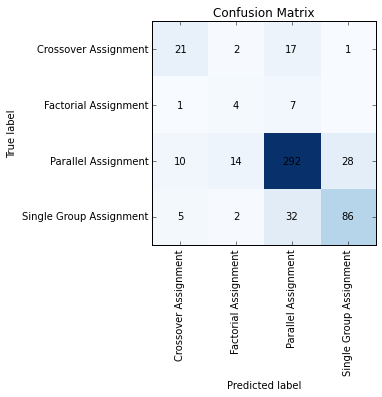

In [15]:
confusion_matrix = sklearn.metrics.confusion_matrix(ys_test, predictions)

fig = plt.figure()
plt.clf()

labels = best_clf.classes_

plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')

width = height = len(labels)

for x in xrange(width):
    for y in xrange(height):
        plt.annotate(str(confusion_matrix[x][y]) if confusion_matrix[x][y] else '', xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

### Features with Highest Coefficients

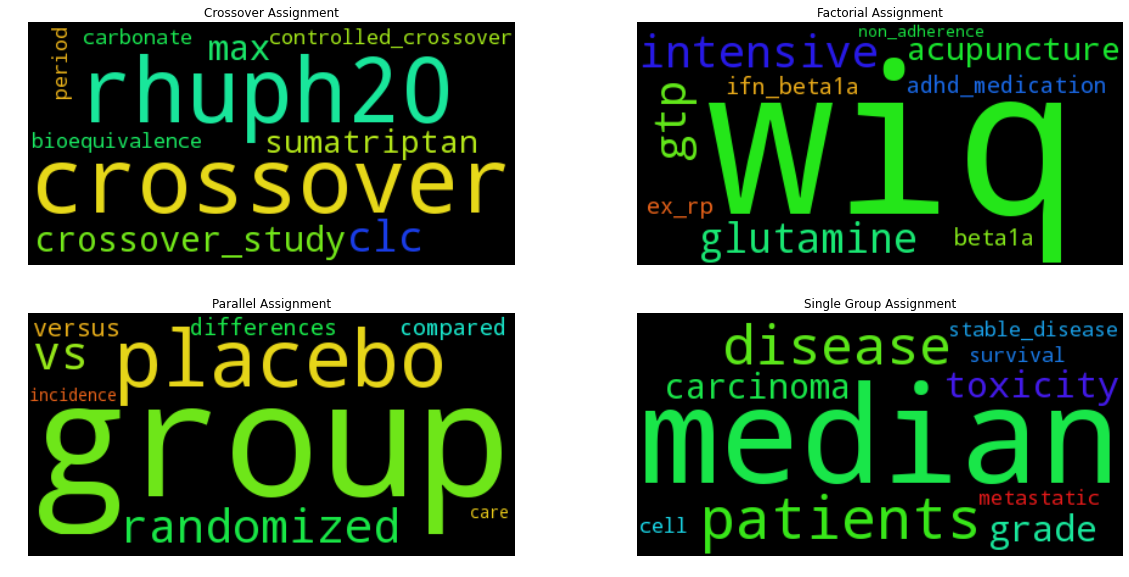

In [18]:
import re

fig = plt.figure(figsize=(20, 20))
plt.clf()

for i, (weights, title) in enumerate(zip(best_clf.coef_, labels), start=1):
    pairs = sorted(zip(weights, vocabulary), reverse=True)[:10]
    pairs = [(pair[0], re.sub('\s+', '_', pair[1])) for pair in pairs]
    
    def duplicate_words(pairs):
        """Yields words duplicated proportional to their corresponding coefficients"""
        
        for coef, word in pairs:
            for _ in range(int(coef*100)):
                yield word
            
    duped_words = list(duplicate_words(pairs))
    
    axes = fig.add_subplot(4, 2, i)
    word_cloud(' '.join(duped_words), axes, title)
    
plt.axis('off')
plt.show()